## Name: Shivkumar G. Chauhan
### Roll No.: CS8A53
### Batch A-3
---
# Applied Data Science

## imports

In [1]:
import pandas
import numpy
import warnings
import matplotlib.pyplot as pyplot

import scipy.stats
from sklearn import preprocessing

## Configurations

In [2]:
StandardScaler=preprocessing.StandardScaler(
    with_mean=False,
    with_std=True
)
Normalizer=preprocessing.Normalizer(
    norm='max'
)

In [54]:
# %matplotlib qt
%matplotlib inline
pyplot.rcParams["figure.figsize"] = (15, 12)

hiding warnings

In [3]:
warnings.filterwarnings('ignore')

Initializing Functions

In [34]:
def normalDistributionGraphGenarator(
    data:numpy.array,
    *ExtraArguments
)->None:
    """Normalization graph plotter function

    Args:
        data (numpy.array): Any Array or DataFrame Column
    """
    pyplot.figure('Normal Distribution Graph')
    data=numpy.sort(data)
    pyplot.plot(data, scipy.stats.norm.pdf(
        data, 
        numpy.mean(data),
        numpy.std(data))
    )
    for data in ExtraArguments:
        data=numpy.sort(data)
        pyplot.plot(data, 
            scipy.stats.norm.pdf(
            data, 
            numpy.mean(data),
            numpy.std(data))
    )
    pyplot.xlabel('values')
    pyplot.ylabel("Normalized Values")

In [35]:
def generateClusters(data:pandas.DataFrame,column_name:str,number_of_clusters=5)->list:
    """ Function for getting clusters using Kmeans Method
        Only Numerical Column is allowed

    Args:
        data (pandas.DataFrame): DataFrame Copy
        column_name (str): Specific Column Name
        number_of_clusters (int, optional): number of required clusters . Defaults to 5.

    Returns:
        list: list of DataFrames
    """
    Samples=[]
    column_data=data[column_name]
    cluster_centers,_=kmeans(
        column_data.to_numpy(),
        k_or_guess=number_of_clusters
    )
    cluster_indexes,_ = vq(
        column_data.to_numpy(),
        cluster_centers
    )
    data["cluster_value"]=cluster_indexes
    for i in range(number_of_clusters):
        Samples.append(
            data[data["cluster_value"]==i].sort_values(by=column_name,
                                                       ascending=False
    ).reset_index(
                drop=True
    ).drop(
        ['cluster_value'],axis=1)
    )
    data=data.drop(['cluster_value'],axis=1)
    return Samples

In [195]:
def PreprocessTheCovidData(Main_Data:pandas.DataFrame,Selected_columns:list,isCumulative=False)->pandas.DataFrame:
    """Final Function for Whole Data Processing for Covid Data

    Args:
        Main_Data (pandas.DataFrame): Initial Raw Data
        Selected_columns (list): list of columns that to bet selected

    Returns:
        pandas.DataFrame: Preprocessed Data
    """
    Main_Data=Main_Data[Selected_Columns]
    if isCumulative:
        for index in Main_Data['location'].value_counts().index:
            if len(Main_Data[Main_Data['location']==index]['total_cases'].unique())<2:
                Main_Data=Main_Data[Main_Data['location']!=index]
    for index in Main_Data[Main_Data['continent'].isnull()==True]['location'].value_counts().index:
        if index.find("income")!=-1:
            Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(value={"continent":"Income Based"})
        elif index.find("Europe")!=-1:
            Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(value={"continent":"Europe"})
        elif index.find("International")!=-1 or index.find("World")!=-1:
            Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(value={"continent":"World"})
        else:
            Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(value={"continent":index})
    for index in Main_Data[Main_Data['life_expectancy'].isnull()==False]['continent'].value_counts().index:
        Main_Data[Main_Data['continent']==index]=Main_Data[Main_Data['continent']==index].fillna(value={"life_expectancy":Main_Data[Main_Data['continent']==index]['life_expectancy'].mean()})
    Main_Data=Main_Data.fillna(value={"life_expectancy":Main_Data['life_expectancy'].mean()})
    Main_Data['population']=Main_Data['population'].fillna(Main_Data[Main_Data['location']=='International']['total_cases'].max())
    Main_Data[['new_cases','new_deaths']]=Main_Data[['new_cases','new_deaths']].fillna(0)
    for index in Main_Data['location'].value_counts().index:
        Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(0,limit=1)
        Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(method='ffill')
    return Main_Data

reading dataset

In [4]:
Raw_Data=pandas.read_csv("../Data/Raw_Data/owid-covid-data.csv",date_parser='date')

FileNotFoundError: [Errno 2] No such file or directory: '../Data/Raw_Data/owid-covid-data.csv'

Sorting the Dataframe using total_cases column

selecting specific columns

In [ ]:
Raw_Data=Raw_Data.sort_values(
    by="total_cases",
    ascending=False
).reset_index(drop=True)

In [ ]:
Selected_Columns=['iso_code','date', 'continent', 'location', 'total_cases','new_cases', 'total_deaths', 'new_deaths','population','life_expectancy']

Location Specific Data

Recently Updated Data

In [ ]:
location="World"

In [ ]:
recent_date=Raw_Data['date'][0]
Recent_Data=Raw_Data[Raw_Data['date']==recent_date]

In [ ]:
Location_Specific_Data=Raw_Data[
    Raw_Data['location']==location
]

# Data Exploration

## Raw Data

printing Checking of Raw dataset

In [142]:
Raw_Data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,OWID_WRL,NaN,World,2023-02-12,672789992.0,76746.0,168124.000,6853702.0,369.0,1247.286,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
1,OWID_WRL,NaN,World,2023-02-11,672713246.0,131483.0,169768.429,6853333.0,622.0,1268.857,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
2,OWID_WRL,NaN,World,2023-02-10,672581763.0,142758.0,165649.000,6852711.0,1422.0,1733.286,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
3,OWID_WRL,NaN,World,2023-02-09,672440247.0,257000.0,179259.857,6851332.0,2259.0,1851.000,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
4,OWID_WRL,NaN,World,2023-02-08,672183247.0,228269.0,179518.429,6849409.0,1896.0,1908.429,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN


printing different statistics of dataset like mean, quantiles, min, max etc.

In [143]:
Raw_Data.describe(include="all")

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,257015,242587,257015,257015,2.425620e+05,2.422160e+05,2.410120e+05,2.229170e+05,222814.000000,221628.000000,...,154495.000000,101880.000000,184148.000000,235807.000000,201879.000000,2.559130e+05,8.531000e+03,8531.000000,8531.000000,8531.000000
unique,248,6,248,1139,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,MEX,Europe,Mexico,2021-11-09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1139,58802,1139,247,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,5.249953e+06,1.184319e+04,1.189204e+04,7.958587e+04,127.809734,128.391436,...,32.820334,50.900699,3.089301,73.596906,0.724549,1.405575e+08,5.167216e+04,10.313593,14.114181,1490.624400
std,NaN,NaN,NaN,NaN,3.231413e+07,8.230481e+04,8.001572e+04,4.056417e+05,739.516653,685.526668,...,13.539007,31.884795,2.551590,7.446936,0.149554,6.917380e+08,1.407291e+05,13.242279,25.822521,1831.869984
min,NaN,NaN,NaN,NaN,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000,0.000000,...,7.700000,1.188000,0.100000,53.280000,0.394000,4.700000e+01,-3.772610e+04,-28.450000,-95.920000,-1984.281600
25%,NaN,NaN,NaN,NaN,5.678000e+03,0.000000e+00,4.571000e+00,1.230000e+02,0.000000,0.000000,...,21.600000,20.859000,1.300000,69.500000,0.602000,8.367830e+05,8.600001e+01,1.045000,0.250000,51.556450
50%,NaN,NaN,NaN,NaN,6.171400e+04,3.800000e+01,7.828600e+01,1.352000e+03,0.000000,1.143000,...,33.100000,49.839000,2.500000,75.050000,0.742000,6.948395e+06,6.983201e+03,7.970000,7.580000,927.002100
75%,NaN,NaN,NaN,NaN,6.369140e+05,8.300000e+02,1.012571e+03,1.094500e+04,12.000000,13.571000,...,41.300000,83.241000,4.200000,79.070000,0.838000,3.369661e+07,3.765704e+04,16.310000,19.180000,2399.098100


printing the dataset information like column values counts, column value data type

In [144]:
Raw_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257015 entries, 0 to 257014
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    257015 non-null  object 
 1   continent                                   242587 non-null  object 
 2   location                                    257015 non-null  object 
 3   date                                        257015 non-null  object 
 4   total_cases                                 242562 non-null  float64
 5   new_cases                                   242216 non-null  float64
 6   new_cases_smoothed                          241012 non-null  float64
 7   total_deaths                                222917 non-null  float64
 8   new_deaths                                  222814 non-null  float64
 9   new_deaths_smoothed                         221628 non-null  float64
 

## Location Specific Data

Printing Location Specific Data

In [145]:
Location_Specific_Data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,OWID_WRL,NaN,World,2023-02-12,672789992.0,76746.0,168124.000,6853702.0,369.0,1247.286,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
1,OWID_WRL,NaN,World,2023-02-11,672713246.0,131483.0,169768.429,6853333.0,622.0,1268.857,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
2,OWID_WRL,NaN,World,2023-02-10,672581763.0,142758.0,165649.000,6852711.0,1422.0,1733.286,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
3,OWID_WRL,NaN,World,2023-02-09,672440247.0,257000.0,179259.857,6851332.0,2259.0,1851.000,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
4,OWID_WRL,NaN,World,2023-02-08,672183247.0,228269.0,179518.429,6849409.0,1896.0,1908.429,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN


printing different statistics of dataset like mean, quantiles, min, max etc.

In [146]:
Location_Specific_Data.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,1.118000e+03,1.118000e+03,1.113000e+03,1.118000e+03,1118.000000,1113.000000,1118.000000,1118.000000,1113.000000,1118.000000,...,1.118000e+03,1.118000e+03,1118.000,1118.00,1.118000e+03,1.118000e+03,0.0,0.0,0.0,0.0
mean,2.683370e+08,6.003492e+05,6.026463e+05,3.799553e+06,6097.053667,6121.513426,33646.828918,75.277906,75.565928,476.426695,...,3.463500e+01,6.013000e+01,2.705,72.58,7.370000e-01,7.975105e+09,NaN,NaN,NaN,NaN
std,2.348252e+08,5.935444e+05,5.682012e+05,2.421545e+06,4389.416540,3834.947046,29444.779815,74.424638,71.246868,303.638069,...,7.108607e-15,7.108607e-15,0.000,0.00,1.110720e-16,0.000000e+00,NaN,NaN,NaN,NaN
min,5.570000e+02,0.000000e+00,3.388570e+02,1.700000e+01,0.000000,9.286000,0.070000,0.000000,0.042000,0.002000,...,3.463500e+01,6.013000e+01,2.705,72.58,7.370000e-01,7.975105e+09,NaN,NaN,NaN,NaN
25%,4.416838e+07,2.798618e+05,3.083566e+05,1.238696e+06,2297.000000,2203.000000,5538.281750,35.091750,38.665000,155.320000,...,3.463500e+01,6.013000e+01,2.705,72.58,7.370000e-01,7.975105e+09,NaN,NaN,NaN,NaN
50%,1.997513e+08,4.816950e+05,4.978420e+05,4.267262e+06,5902.500000,6071.429000,25046.858500,60.400000,62.425000,535.073000,...,3.463500e+01,6.013000e+01,2.705,72.58,7.370000e-01,7.975105e+09,NaN,NaN,NaN,NaN
75%,5.183744e+08,6.824970e+05,6.460574e+05,6.281390e+06,8832.250000,9216.143000,64999.070750,85.578000,81.009000,787.624750,...,3.463500e+01,6.013000e+01,2.705,72.58,7.370000e-01,7.975105e+09,NaN,NaN,NaN,NaN
max,6.727900e+08,4.082889e+06,3.436560e+06,6.853702e+06,60788.000000,14860.286000,84361.270000,511.954000,430.911000,859.387000,...,3.463500e+01,6.013000e+01,2.705,72.58,7.370000e-01,7.975105e+09,NaN,NaN,NaN,NaN


## Recently Updated Data

Printing Recently Updated Data

In [186]:
Recent_Data

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,OWID_WRL,NaN,World,2023-02-12,672789992.0,76746.0,168124.000,6853702.0,369.0,1247.286,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
355,OWID_HIC,NaN,High income,2023-02-12,428947809.0,57908.0,140305.143,2855457.0,257.0,1065.857,...,NaN,NaN,NaN,NaN,NaN,1.250515e+09,NaN,NaN,NaN,NaN
811,OWID_EUR,NaN,Europe,2023-02-12,247078476.0,21757.0,45771.714,2027034.0,51.0,384.714,...,NaN,NaN,NaN,NaN,NaN,7.448078e+08,NaN,NaN,NaN,NaN
1134,OWID_ASI,NaN,Asia,2023-02-12,209906439.0,38544.0,65275.571,1619549.0,248.0,286.286,...,NaN,NaN,NaN,NaN,NaN,4.721383e+09,NaN,NaN,NaN,NaN
1440,OWID_EUN,NaN,European Union,2023-02-12,183299960.0,8336.0,30078.000,1210060.0,14.0,280.571,...,NaN,NaN,NaN,NaN,NaN,4.501468e+08,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202413,MSR,North America,Montserrat,2023-02-12,1403.0,0.0,0.000,8.0,0.0,0.000,...,NaN,NaN,NaN,74.16,NaN,4.413000e+03,NaN,NaN,NaN,NaN
208578,OWID_INT,NaN,International,2023-02-12,721.0,0.0,0.000,15.0,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
228398,VAT,Europe,Vatican,2023-02-12,29.0,0.0,0.000,NaN,NaN,NaN,...,NaN,NaN,NaN,75.12,NaN,8.080000e+02,NaN,NaN,NaN,NaN
242240,PRK,Asia,North Korea,2023-02-12,1.0,0.0,0.000,6.0,0.0,0.000,...,NaN,NaN,13.200,72.27,NaN,2.606942e+07,NaN,NaN,NaN,NaN


printing different statistics of dataset like mean, quantiles, min, max etc.

In [149]:
Recent_Data.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,2.310000e+02,188.000000,188.000000,2.270000e+02,208.000000,208.000000,230.000000,187.000000,187.000000,226.000000,...,145.000000,95.000000,172.000000,218.000000,189.000000,2.310000e+02,0.0,0.0,0.0,0.0
mean,1.244339e+07,1677.234043,3556.424761,1.261003e+05,7.163462,23.746577,186885.415526,24.257273,24.545460,1255.897407,...,32.909897,50.270832,3.071994,73.393440,0.722540,1.398762e+08,NaN,NaN,NaN,NaN
std,5.941804e+07,7994.240279,17628.446516,5.773880e+05,37.464859,126.375969,190865.434408,144.432690,84.151325,1288.606480,...,13.621757,31.889658,2.541906,7.482858,0.149793,6.903625e+08,NaN,NaN,NaN,NaN
min,1.000000e+00,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.038000,0.000000,0.000000,0.230000,...,7.700000,1.188000,0.100000,53.280000,0.394000,8.080000e+02,NaN,NaN,NaN,NaN
25%,3.215250e+04,0.000000,0.000000,2.975000e+02,0.000000,0.000000,16364.635000,0.000000,0.000000,169.466500,...,22.600000,20.105000,1.300000,68.532500,0.602000,8.227550e+05,NaN,NaN,NaN,NaN
50%,2.868670e+05,0.000000,1.286000,3.164000e+03,0.000000,0.000000,122721.342500,0.000000,0.171000,787.118000,...,33.100000,49.542000,2.450000,74.705000,0.740000,7.488863e+06,NaN,NaN,NaN,NaN
75%,2.196799e+06,41.000000,46.500250,2.138400e+04,0.000000,0.571000,313389.849000,1.089500,12.369500,2023.891500,...,41.300000,81.568500,4.050000,78.875000,0.829000,3.358624e+07,NaN,NaN,NaN,NaN
max,6.727900e+08,76746.000000,168124.000000,6.853702e+06,369.000000,1247.286000,720435.220000,1613.025000,838.564000,6439.696000,...,78.100000,98.999000,13.800000,86.750000,0.957000,7.975105e+09,NaN,NaN,NaN,NaN


In [150]:
Recent_Data.copy().reset_index()

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,0,OWID_WRL,NaN,World,2023-02-12,672789992.0,76746.0,168124.000,6853702.0,369.0,...,34.635,60.13,2.705,72.58,0.737,7.975105e+09,NaN,NaN,NaN,NaN
1,355,OWID_HIC,NaN,High income,2023-02-12,428947809.0,57908.0,140305.143,2855457.0,257.0,...,NaN,NaN,NaN,NaN,NaN,1.250515e+09,NaN,NaN,NaN,NaN
2,811,OWID_EUR,NaN,Europe,2023-02-12,247078476.0,21757.0,45771.714,2027034.0,51.0,...,NaN,NaN,NaN,NaN,NaN,7.448078e+08,NaN,NaN,NaN,NaN
3,1134,OWID_ASI,NaN,Asia,2023-02-12,209906439.0,38544.0,65275.571,1619549.0,248.0,...,NaN,NaN,NaN,NaN,NaN,4.721383e+09,NaN,NaN,NaN,NaN
4,1440,OWID_EUN,NaN,European Union,2023-02-12,183299960.0,8336.0,30078.000,1210060.0,14.0,...,NaN,NaN,NaN,NaN,NaN,4.501468e+08,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,202413,MSR,North America,Montserrat,2023-02-12,1403.0,0.0,0.000,8.0,0.0,...,NaN,NaN,NaN,74.16,NaN,4.413000e+03,NaN,NaN,NaN,NaN
228,208578,OWID_INT,NaN,International,2023-02-12,721.0,0.0,0.000,15.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,228398,VAT,Europe,Vatican,2023-02-12,29.0,0.0,0.000,NaN,NaN,...,NaN,NaN,NaN,75.12,NaN,8.080000e+02,NaN,NaN,NaN,NaN
230,242240,PRK,Asia,North Korea,2023-02-12,1.0,0.0,0.000,6.0,0.0,...,NaN,NaN,13.200,72.27,NaN,2.606942e+07,NaN,NaN,NaN,NaN


# Data Preprocessing

In [197]:
Main_Data=PreprocessTheCovidData(
    Recent_Data.copy().sort_values(by='date',ascending=True).reset_index(drop=True),
    Selected_Columns
)

In [198]:
Main_Data

,iso_code,date,continent,location,total_cases,new_cases,total_deaths,new_deaths,population,life_expectancy
0,OWID_WRL,2023-02-12,World,World,672789992.0,76746.0,6853702.0,369.0,7.975105e+09,72.580000
1,SWZ,2023-02-12,Africa,Eswatini,74158.0,15.0,1423.0,0.0,1.201680e+06,60.190000
2,GUY,2023-02-12,South America,Guyana,73032.0,0.0,1297.0,0.0,8.087270e+05,69.910000
3,BLZ,2023-02-12,North America,Belize,70697.0,0.0,688.0,0.0,4.052850e+05,74.620000
4,FJI,2023-02-12,Oceania,Fiji,68864.0,0.0,883.0,0.0,9.297690e+05,67.440000
...,...,...,...,...,...,...,...,...,...,...
227,PAN,2023-02-12,North America,Panama,1030214.0,0.0,8599.0,0.0,4.408582e+06,78.510000
228,MNG,2023-02-12,Asia,Mongolia,1007888.0,0.0,2136.0,0.0,3.398373e+06,69.870000
229,NPL,2023-02-12,Asia,Nepal,1001115.0,2.0,12020.0,0.0,3.054759e+07,70.780000
230,HRV,2023-02-12,Europe,Croatia,1268224.0,39.0,17923.0,2.0,4.030361e+06,78.490000


# Data Visualization

##### Normalization Graphs Plotter

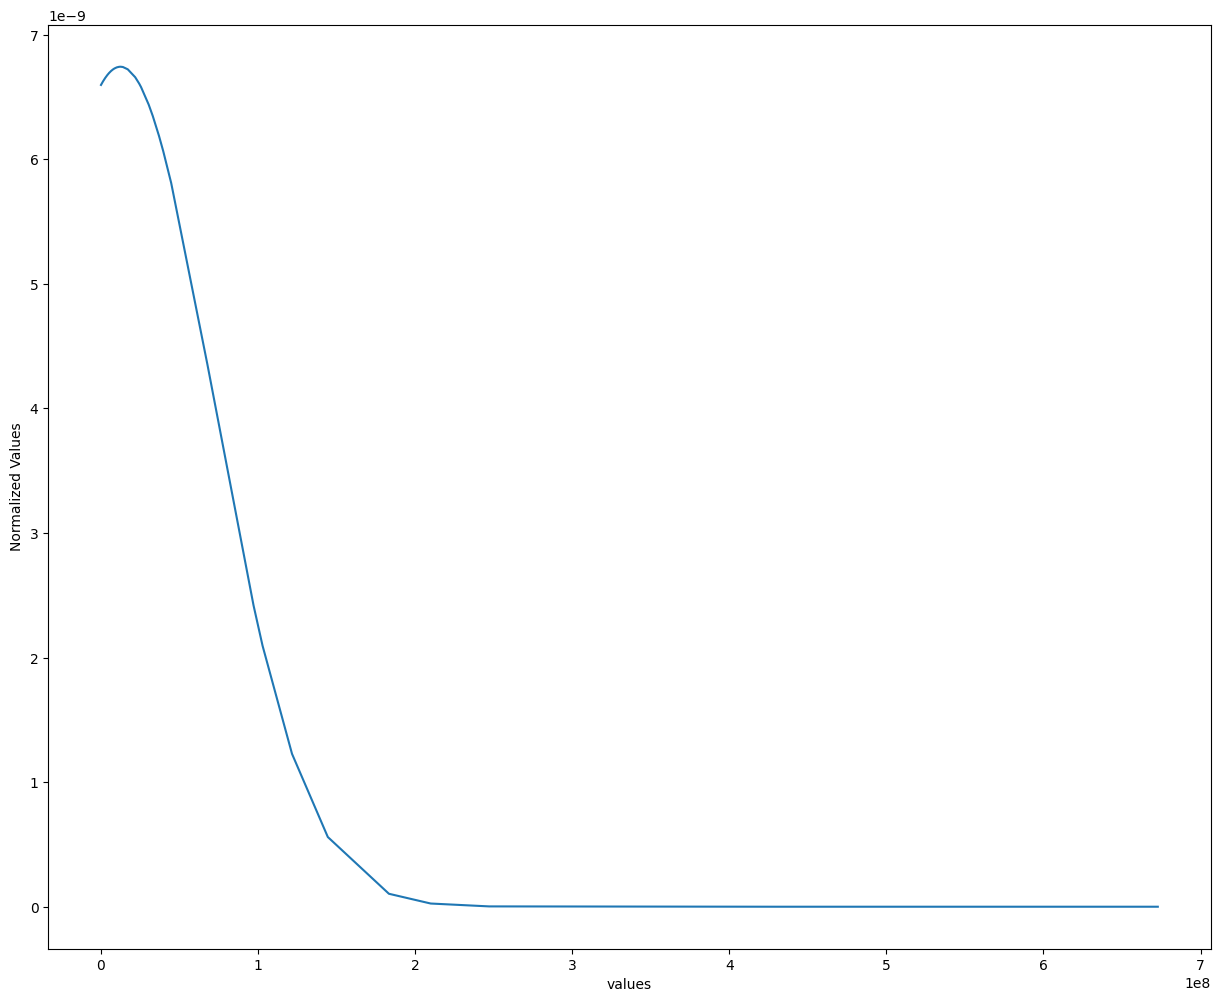

In [199]:
normalDistributionGraphGenarator(Main_Data['total_cases'])

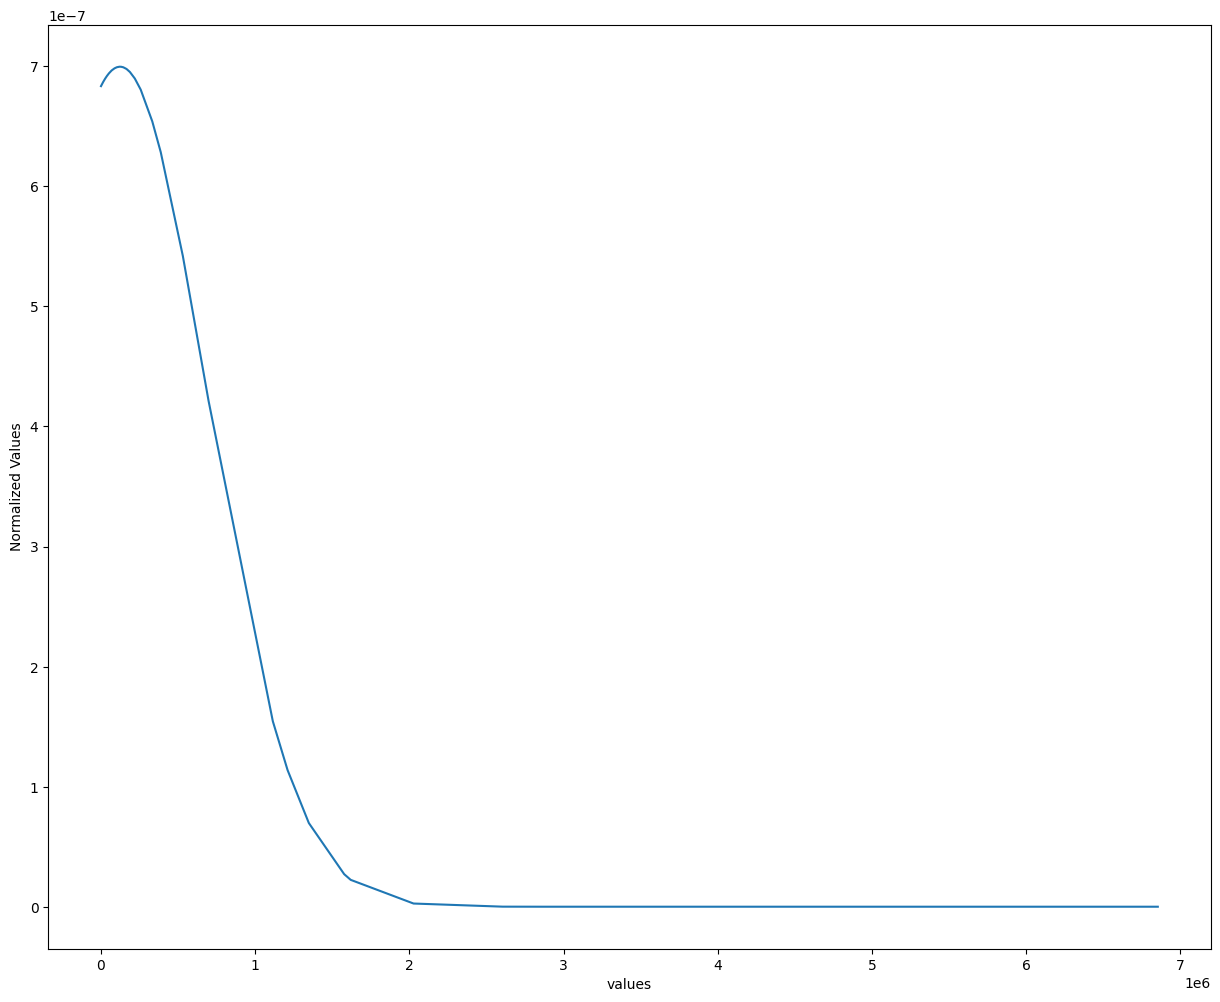

In [201]:
normalDistributionGraphGenarator(Main_Data['total_deaths'])

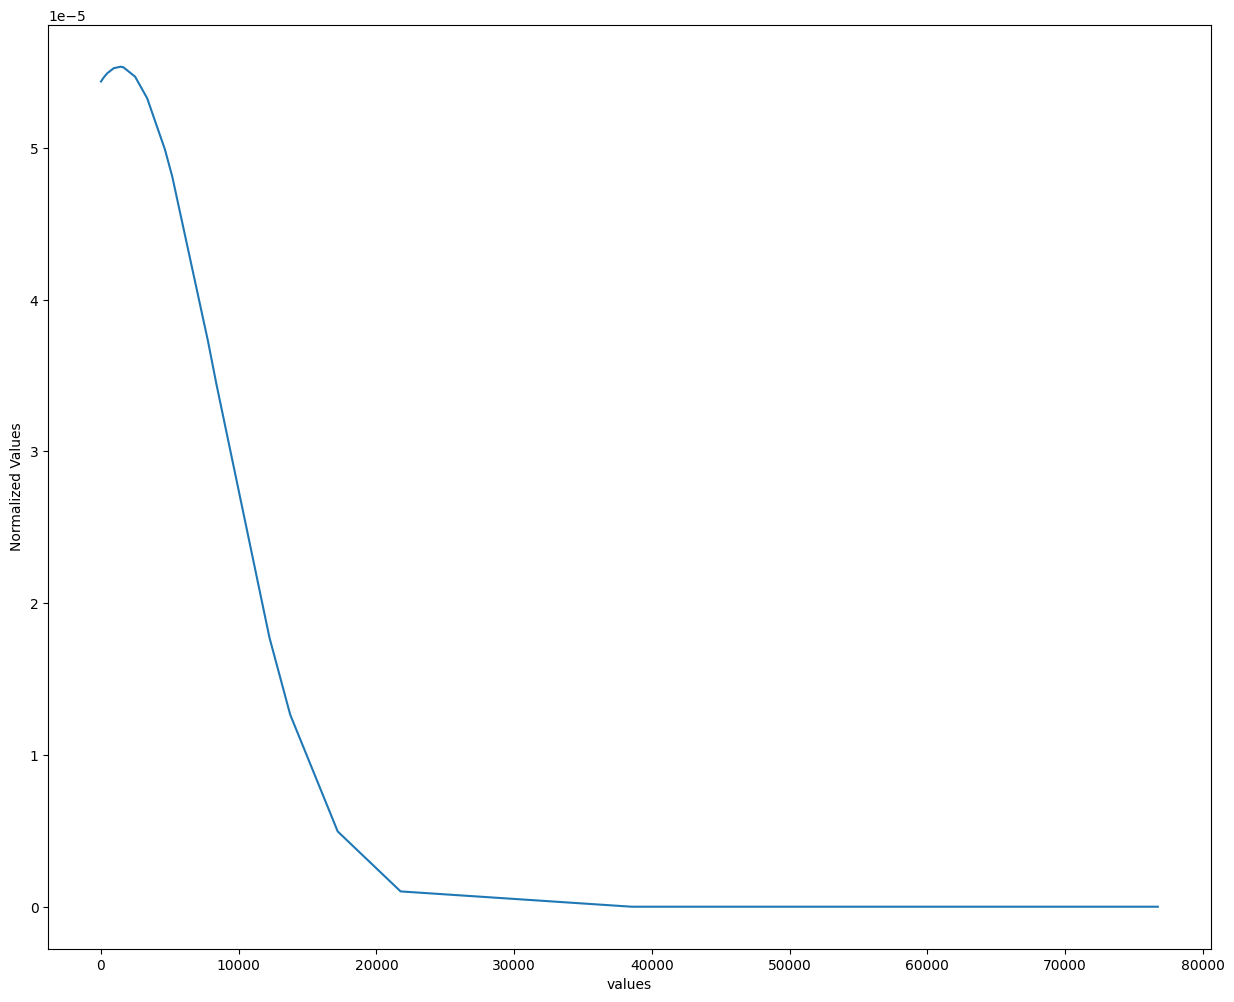

In [200]:
normalDistributionGraphGenarator(Main_Data['new_cases'])

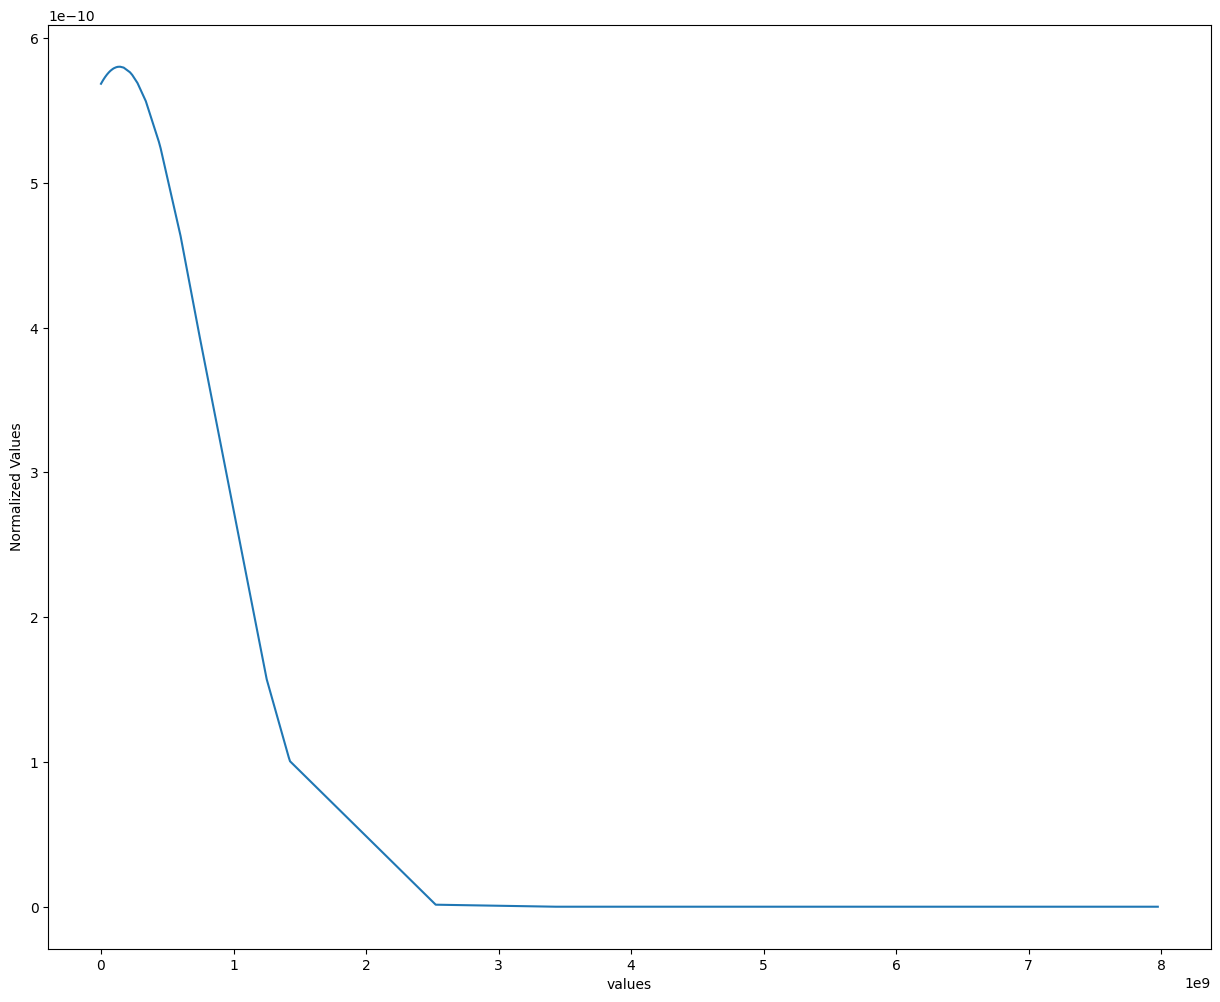

In [202]:
normalDistributionGraphGenarator(Main_Data['population'])

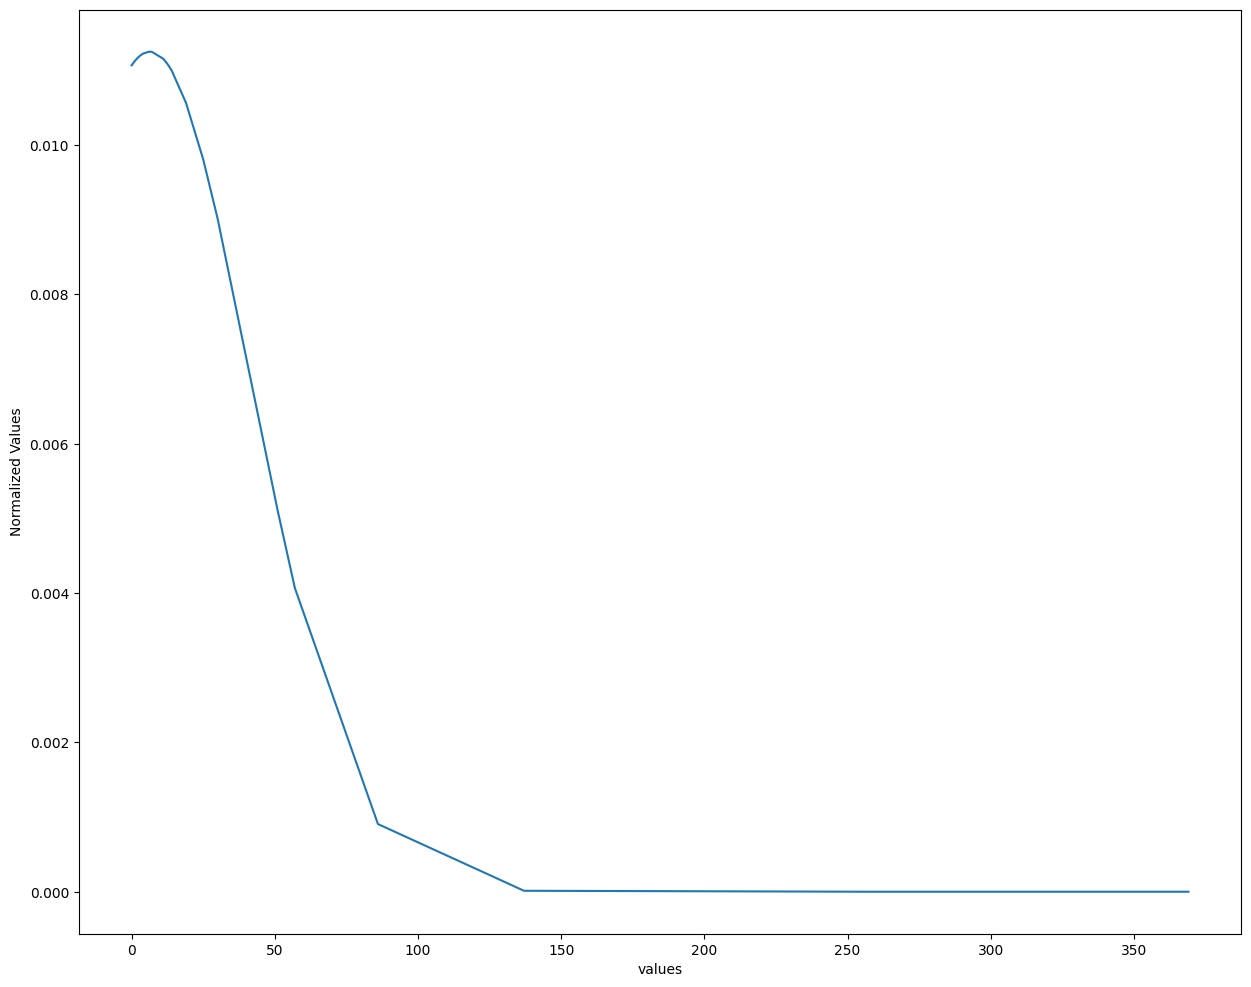

In [203]:
normalDistributionGraphGenarator(Main_Data['new_deaths'])

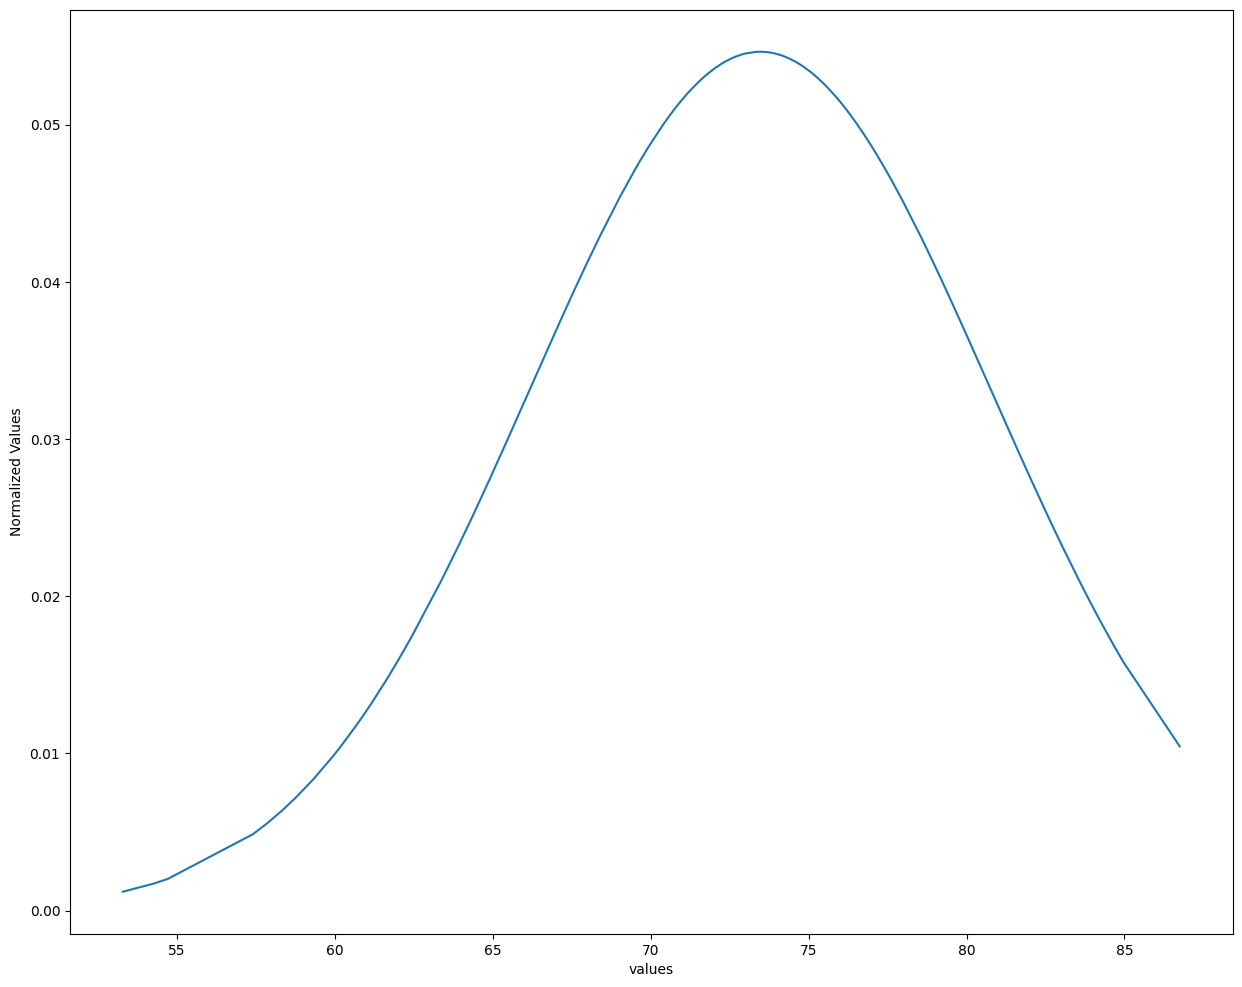

In [204]:
normalDistributionGraphGenarator(Main_Data['life_expectancy'])